In [85]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown

Рассматривается население Швейцарии в период с 1900 по 2021 год.

,year,pop
0,1900,3300000
1,1901,3341000
2,1902,3384000
3,1903,3428000
4,1904,3472000
...,...,...
117,2017,8482000
118,2018,8542300
119,2019,8603900
120,2020,8667100


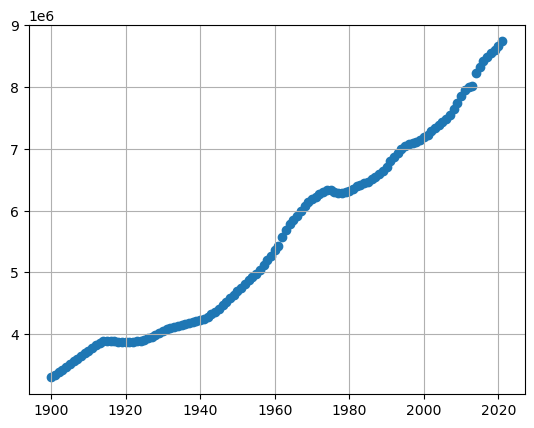

In [86]:
population = pd.read_excel('population.xlsx', usecols="A, B")
display(population)

x = np.array(population['year'])
y = np.array(population['pop'])

# To check prediction.
y_ref = 8776000
x_ref = 2022

lin = np.linspace(min(x), max(x))

plt.scatter(x, y)

plt.grid()


### Least squares method

Reference: 8.776e+06
Interpolation: 8.707e+06
Error: -6.9e+04 (0.78%)


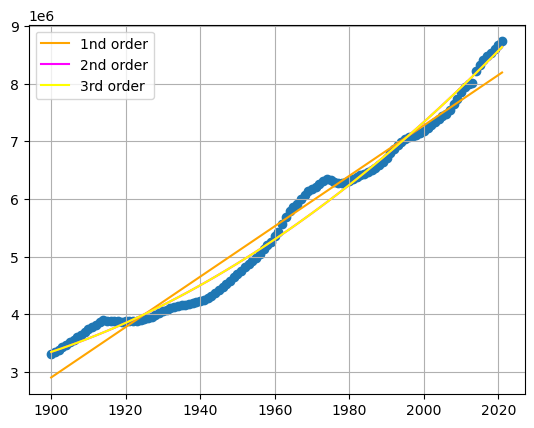

In [87]:
phi1 = np.array([
    lambda x: 1,
    lambda x: x,
])

phi2 = np.array([
    lambda x: 1,
    lambda x: x,
    lambda x: x**2,
])

phi3 = np.array([
    lambda x: 1,
    lambda x: x,
    lambda x: x**2,
    lambda x: x**3,
])

def leastSquares(x, y, phi):
    assert len(x) == len(y), "x and y must have same size"
    assert len(x) > len(phi), "number of knots must be higher than approximation order"
    dim = len(x)

    phi_im = np.array([[phi_i(x_m) for x_m in x] for phi_i in phi])

    free_i = np.matmul(phi_im, y)
    gram_ij = np.matmul(phi_im, phi_im.T)

    sols_j = np.linalg.solve(gram_ij, free_i)

    return lambda arg: np.array([np.sum([sol_i * phi_i(arg_m) for (sol_i, phi_i) in zip(sols_j, phi)]) for arg_m in np.atleast_1d(arg)])

equ1 = leastSquares(x, y, phi1)
equ2 = leastSquares(x, y, phi2)
equ3 = leastSquares(x, y, phi3)

plt.plot(lin, equ1(lin), c='orange', label='1nd order')
plt.plot(lin, equ2(lin), c='magenta',  label='2nd order')
plt.plot(lin, equ3(lin), c='yellow', label='3rd order')
plt.scatter(x, y)

predict = equ3(x_ref).item()
print(f"Reference: {y_ref:.4g}")
print(f"Interpolation: {predict:.4g}")
print(f"Error: {predict - y_ref:.2g} ({np.abs((y_ref - predict) / y_ref * 100):.2f}%)")

plt.legend()
plt.grid()


### Polynomial Interpolation

,year.1,pop.1
0,1900.0,3300000.0
1,1910.0,3735000.0
2,1920.0,3877000.0
3,1930.0,4051000.0
4,1940.0,4226000.0
5,1950.0,4694000.0
6,1960.0,5362000.0
7,1970.0,6181000.0
8,1980.0,6319000.0
9,1990.0,6712000.0


Reference: 4.98e+06
Interpolation: 4.975e+06
Error: -4.8e+03 (0.10%)


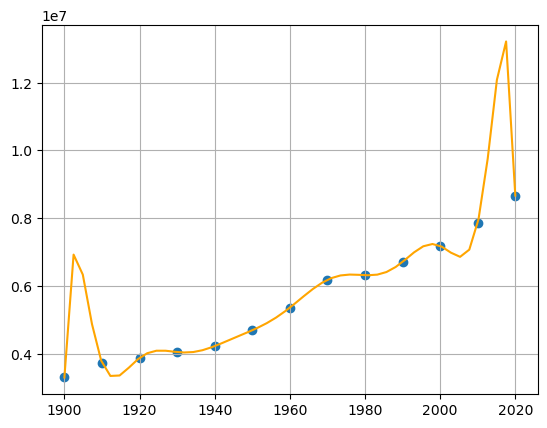

In [88]:
# For polynomial interpolation we will use "thinned out" data (otherwise it become completely incorrect)
population = pd.read_excel('population.xlsx', usecols="G, H")
population = population.dropna()
display(population)

x_th = np.array(population['year.1'])
y_th = np.array(population['pop.1'])

def polyInterp(x, y):
    assert len(x) == len(y), "x and y must have same size"
    dim = len(x)
    order = len(x)

    b_im = np.zeros((order, dim))
    b_im[0] = y
    for i in range(1, order):
        prev_m = b_im[i-1]
        b_im[i][0:order-i] = [(prev_m[m+1] - prev_m[m])/(x[m+i] - x[m]) for m in range(0, order - i)]

    def poly(arg, b_im, x, pivot):
        bpivot_m = b_im[pivot]
        val = bpivot_m[order-1]
        for m in reversed(range(0, order-1)):
            val = bpivot_m[m] + (arg - x[m]) * val

        return val

    return lambda arg: poly(arg, b_im.T, x, 0)

equ = polyInterp(x_th, y_th)
lin = np.linspace(min(x_th), max(x_th))
plt.plot(lin, equ(lin), c='orange')
plt.scatter(x_th, y_th)

# For prediction, a value in the middle is used because of the innacuracy og the method on borders.
predict = equ(x[55])
print(f"Reference: {y[55]:.4g}")
print(f"Interpolation: {predict:.4g}")
print(f"Error: {predict - y[55]:.2g} ({np.abs((y[55] - predict) / y[55] * 100):.2f}%)")

plt.grid()

### Spline Interpolation

Reference: 8.776e+06
Interpolation: 8.806e+06
Error: 3e+04 (0.34%)


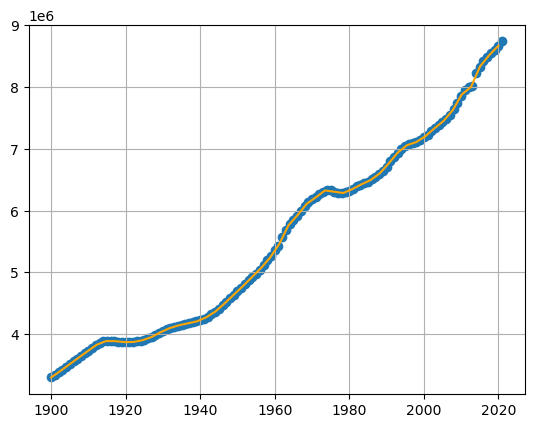

In [89]:
def norm(vec):
    return np.linalg.norm(vec, ord=np.inf)

# All indecies are shifted by 1 towards 0.
def solveTridiagonal(mat, f):
    shape = mat.shape
    dim = len(f)
    assert shape[0] == dim and shape[1] == dim, "dimensions must be equal"

    a = np.diag(mat, -1)
    b = np.diag(mat,  0).copy()
    c = np.diag(mat,  1)
    d = f.copy()

    for i in range(1, dim):
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    x = np.zeros(dim)
    x[dim-1] = d[dim-1] / b[dim-1]
    for i in reversed(range(0, dim-1)):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]

    diff = np.matmul(mat, x) - f
    assert norm(diff) < 1e-9, 'tridiagonal method diverged, solution is incorrect'

    return x

def splineInterp(x, y):
    assert len(x) == len(y), "x and y must have same size"
    dim = len(x)

    # Construct x steps; m = [1, dim)
    h_m = np.zeros(dim)
    for m in range(1, dim):
        h_m[m] = x[m] - x[m-1]

    # Construct mu; m = [1, dim), mu[dim - 1] = 0 from simple boundary conditions
    mu_m = np.zeros(dim)
    for m in range(1, dim - 1):
        mu_m[m] = h_m[m] / (h_m[m] + h_m[m+1])

    # Construct lambda; m = [0, dim - 1), lambda[0] = 0 from simple boundary conditions
    lambda_m = 1 - mu_m
    lambda_m[0] = 0

    # Construct divided differences; m = [0, dim - 2)
    order = len(x)
    b_im = np.zeros((order, dim))
    b_im[0] = y
    for i in range(1, order):
        prev_m = b_im[i-1]
        b_im[i][0:order-i] = [(prev_m[m+1] - prev_m[m])/(x[m+i] - x[m]) for m in range(0, order - i)]

    # Get divided differences for 2nd order
    b_2m = b_im[2]

    # Construct d; m = [0, dim), d[0] = d[dim-1] = 0 from simple boundary conditions
    d_m = np.zeros(dim)
    for m in range(1, dim - 1):
        d_m[m] = 6 * b_2m[m-1]

    # Construct lambda-mu matrix
    mat = np.diag(np.full(dim, 2), 0) + np.diag(mu_m[1:], -1) + np.diag(lambda_m[:-1], 1)

    M_m = solveTridiagonal(mat, d_m)

    def poly(arg):
        m = np.searchsorted(x, arg)
        m = np.clip(m, 1, dim-1)
        val = M_m[m-1] * (x[m] - arg)**3 / (6 * h_m[m])                     \
              + M_m[m] * (arg - x[m-1])**3 / (6 * h_m[m])                   \
              + (y[m-1] - M_m[m-1] * h_m[m]**2 / 6) * (x[m] - arg) / h_m[m] \
              + (y[m] - M_m[m] * h_m[m]**2 / 6) * (arg - x[m-1]) / h_m[m]
        return val

    return lambda arg: poly(arg)

equ = splineInterp(x, y)
plt.plot(lin, equ(lin), c='orange')
plt.scatter(x, y)

predict = equ(x_ref)
print(f"Reference: {y_ref:.4g}")
print(f"Interpolation: {predict:.4g}")
print(f"Error: {predict - y_ref:.2g} ({np.abs((y_ref - predict) / y_ref * 100):.2f}%)")

plt.grid()
